## PySyft Tricky Operations

This notebook covers some tricky pysyft operations that can lead to confusion. Understanding its 'real' behaviour is important for the correct implementation of PySyft applications.

*Note: This notebook requires some basic knowledge of PySyft operations. There is a good [introduction notebook tutorial](https://github.com/mnauf/UdacityFacebookScholar/blob/master/PySyft/examples/tutorials/Part%2001%20-%20The%20Basic%20Tools%20of%20Private%20Deep%20Learning.ipynb) for getting started with PySyft.*

### Imports

In [1]:
import torch as torch
import syft as sy
hook = sy.TorchHook(torch)

In [17]:
jake = sy.VirtualWorker(hook, id="jake")
john = sy.VirtualWorker(hook, id="john")

### 00 - Segregation of responsabilities

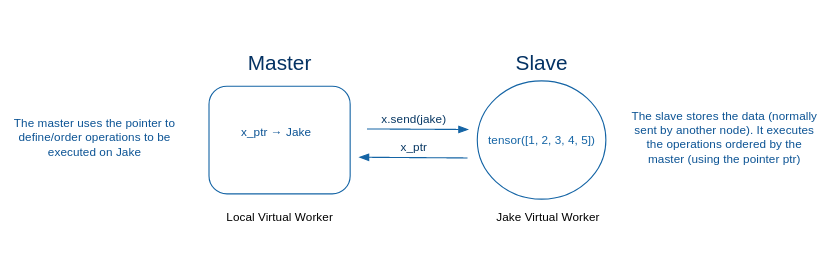

In [28]:
from IPython.display import Image
Image("./img/segregation_responsabilities.png", width = 900,height = 300)

### 01 - Delegated computation

One common operation could be to have one virtual worker (e.g. Jake) delagating computation on another (e.g. John).
In this scenario, Jake stores data a performs operations on it. Jake decides to send the data to John in order to delegate the execution of operations on that data to John.

We have seen that it is imposible to use the virtual worker 'jake' to execute directly operations in order to send itself the data to John.
This orders should be send from *this* local virtual worker node.

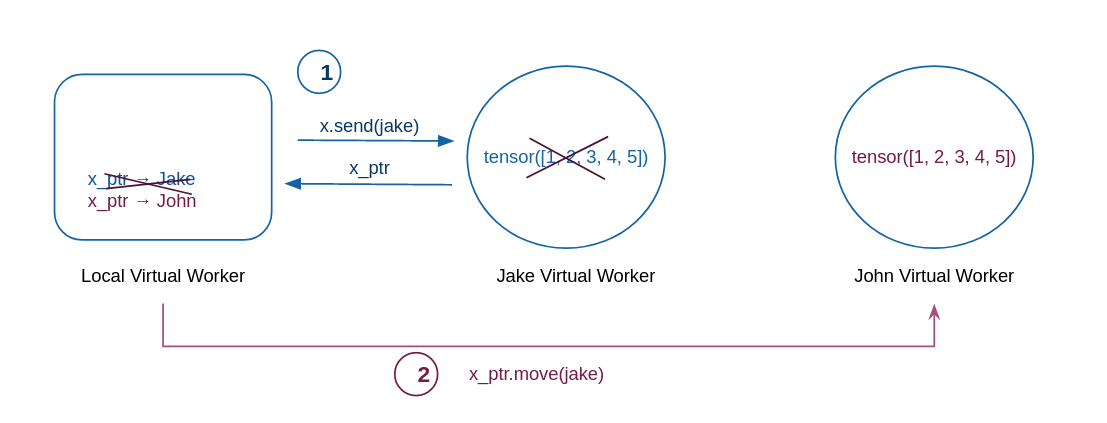

In [27]:
from IPython.display import Image
Image("./img/delegated_computation.png", width = 900,height = 300)

In [4]:
x = torch.tensor([1, 2, 3, 4, 5])

**01 - send the tensor to jake worker and receive a ptr**

In [5]:
x_ptr = x.send(jake)

In [6]:
jake._objects

{42117465396: <Plan Plan id:42117465396 owner:jake Tags: #fss_eq_plan_1 built>,
 68321932213: <Plan Plan id:68321932213 owner:jake Tags: #fss_eq_plan_2 built>,
 43888275621: <Plan Plan id:43888275621 owner:jake Tags: #fss_comp_plan_1 built>,
 35297188242: <Plan Plan id:35297188242 owner:jake Tags: #fss_comp_plan_2 built>,
 3695857258: <Plan Plan id:3695857258 owner:jake Tags: #xor_add_1 built>,
 22730960517: <Plan Plan id:22730960517 owner:jake Tags: #xor_add_2 built>,
 84207671408: tensor([1, 2, 3, 4, 5])}

In [7]:
x_ptr

(Wrapper)>[PointerTensor | me:5316777201 -> jake:84207671408]

The tensor is stored in jake worker memory and we receive a pointer to jake location

**02 - Now, we will try to move this tensor to john**

In [10]:
x_ptr.move(john)

(Wrapper)>[PointerTensor | me:5316777201 -> john:84207671408]

In [13]:
jake._objects

{42117465396: <Plan Plan id:42117465396 owner:jake Tags: #fss_eq_plan_1 built>,
 68321932213: <Plan Plan id:68321932213 owner:jake Tags: #fss_eq_plan_2 built>,
 43888275621: <Plan Plan id:43888275621 owner:jake Tags: #fss_comp_plan_1 built>,
 35297188242: <Plan Plan id:35297188242 owner:jake Tags: #fss_comp_plan_2 built>,
 3695857258: <Plan Plan id:3695857258 owner:jake Tags: #xor_add_1 built>,
 22730960517: <Plan Plan id:22730960517 owner:jake Tags: #xor_add_2 built>}

In [15]:
john._objects

{21829313227: <Plan Plan id:21829313227 owner:john Tags: #fss_eq_plan_1 built>,
 72590315147: <Plan Plan id:72590315147 owner:john Tags: #fss_eq_plan_2 built>,
 3908397350: <Plan Plan id:3908397350 owner:john Tags: #fss_comp_plan_1 built>,
 30933770030: <Plan Plan id:30933770030 owner:john Tags: #fss_comp_plan_2 built>,
 79918589581: <Plan Plan id:79918589581 owner:john Tags: #xor_add_1 built>,
 80450725832: <Plan Plan id:80450725832 owner:john Tags: #xor_add_2 built>,
 84207671408: tensor([1, 2, 3, 4, 5])}

In [16]:
x_ptr

(Wrapper)>[PointerTensor | me:5316777201 -> john:84207671408]

As we can see, we can move the tensor using the pointer from Jake location to John. As we move the tensor, the pointer is automatically updated to point to John location.

### 03 - Sending the pointers to other nodes

Another tricky operation might be to send the pointer received from the virtual worker to another worker. So, one may think that it exists a double indirection.

If we send the pointer to John, we don't get this:
 * x_ptr (john) --> x_ptr (owner) --> data

We get directly:
 * x_ptr (john) --> data    

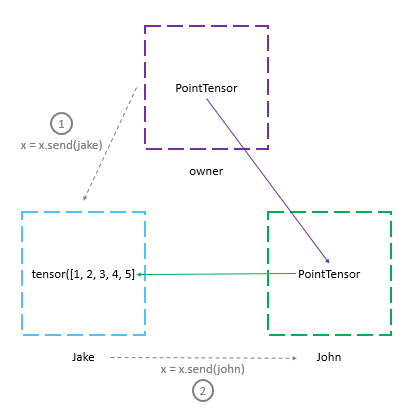

In [30]:
from IPython.display import Image
Image("./img/pointer_triangle.png", width = 500,height = 300)

In [39]:
y = torch.tensor([1, 2, 3, 4, 5])

In [41]:
y_ptr_1 = y.send(jake)
y_ptr_2 = y_ptr_1.send(john)

In [42]:
print("John has: " + str(john._objects))

John has: {21829313227: <Plan Plan id:21829313227 owner:john Tags: #fss_eq_plan_1 built>
, 72590315147: <Plan Plan id:72590315147 owner:john Tags: #fss_eq_plan_2 built>
, 3908397350: <Plan Plan id:3908397350 owner:john Tags: #fss_comp_plan_1 built>
, 30933770030: <Plan Plan id:30933770030 owner:john Tags: #fss_comp_plan_2 built>
, 79918589581: <Plan Plan id:79918589581 owner:john Tags: #xor_add_1 built>
, 80450725832: <Plan Plan id:80450725832 owner:john Tags: #xor_add_2 built>
, 84207671408: tensor([1, 2, 3, 4, 5]), 63029543307: <Plan Plan id:63029543307 owner:john Tags: #fss_eq_plan_1 built>
, 28262692225: <Plan Plan id:28262692225 owner:john Tags: #fss_eq_plan_2 built>
, 98580223650: <Plan Plan id:98580223650 owner:john Tags: #fss_comp_plan_1 built>
, 17903203499: <Plan Plan id:17903203499 owner:john Tags: #fss_comp_plan_2 built>
, 10213327343: <Plan Plan id:10213327343 owner:john Tags: #xor_add_1 built>
, 57026362216: <Plan Plan id:57026362216 owner:john Tags: #xor_add_2 built>
, 9

As we can see we have a pointer to jake location directly

In [43]:
print("Jake has: " + str(jake._objects))

Jake has: {42117465396: <Plan Plan id:42117465396 owner:jake Tags: #fss_eq_plan_1 built>
, 68321932213: <Plan Plan id:68321932213 owner:jake Tags: #fss_eq_plan_2 built>
, 43888275621: <Plan Plan id:43888275621 owner:jake Tags: #fss_comp_plan_1 built>
, 35297188242: <Plan Plan id:35297188242 owner:jake Tags: #fss_comp_plan_2 built>
, 3695857258: <Plan Plan id:3695857258 owner:jake Tags: #xor_add_1 built>
, 22730960517: <Plan Plan id:22730960517 owner:jake Tags: #xor_add_2 built>
, 43565812184: <Plan Plan id:43565812184 owner:jake Tags: #fss_eq_plan_1 built>
, 78347481218: <Plan Plan id:78347481218 owner:jake Tags: #fss_eq_plan_2 built>
, 31167810005: <Plan Plan id:31167810005 owner:jake Tags: #fss_comp_plan_1 built>
, 65060414484: <Plan Plan id:65060414484 owner:jake Tags: #fss_comp_plan_2 built>
, 4635431525: <Plan Plan id:4635431525 owner:jake Tags: #xor_add_1 built>
, 75833104701: <Plan Plan id:75833104701 owner:jake Tags: #xor_add_2 built>
, 81784008147: tensor([1, 2, 3, 4, 5])}
